In [10]:
import os
import sys
#sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from imutils import paths
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random
import pickle
import csv

!export PATH=/Library/TeX/texbin:$PATH

feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

#imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\002_new\\images\\"
#coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-2new-shufflenet.csv'

imgPath = "/home/src21/Documents/bakul_front_face/BuildingAssessment/001"
#imgPath = "/home/src21/Documents/BuildingAssessment/002"

#coordFilePath = "/home/src21/Documents/BuildingAssessment/coordinatesFromPostProcessing-2new-shufflenet.csv"
coordFilePath = "/home/src21/Documents/BuildingAssessment/coordinatesFromPostProcessing-1_new-shufflenet.csv"

windowCount = 0

# Displaying the contents of the text file

# del list

with open(coordFilePath, newline='') as f:
    csvread = csv.reader(f)
    print(csvread)
    batch_data = list(csvread)
print(len(batch_data))

print(batch_data[0])


batch_data_int = []
for inner_list in batch_data:
    innet_out_list = []
    for string in inner_list:
        innet_out_list.append(int(float(string)))
    batch_data_int.append(innet_out_list)

print("bATCH_Data_int:", batch_data_int)
print(len(batch_data_int))
print(batch_data_int[1][0])
FinalList = []
for i in range(len(batch_data_int)):
    el = batch_data_int[i]
    elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
    print("elChunks:", elChunks)
    newElChunks = elChunks.copy()
    for i in range(len(elChunks)):
#         newChunk = newElChunks[i]        
        chunk = elChunks[i]
        newChunk = chunk.copy()
        print("newChunk", newChunk)
        print("chunk", chunk)
        newChunk.insert(2, chunk[0])
        newChunk.insert(3, chunk[3])
        newChunk.insert(6, chunk[2])
        newChunk.insert(7, chunk[1])
        print("newModifiedChunk", newChunk)
        newElChunks[i] = newChunk
    print(newElChunks)
    perImageCoords = np.array(newElChunks)
    perImageCoords = perImageCoords.reshape(-1,4,2)
    FinalList.append(perImageCoords)

print("Final list:", FinalList)
print("Final list size:", len(FinalList))
print("Final list:", FinalList[0].shape)
print("Final list:", FinalList[0])

def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(img_gray, coordinates, padding = 5):
    ret, binary_img = cv2.threshold(img_gray, 255, 255, cv2.THRESH_BINARY)
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

def mapToPick(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

def mapToPickv1(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
#         startX, startY = coordinates[i][0]
#         endX, endY = coordinates[i][2]
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick
    

print(FinalList[-1])
ans = mapToPickv1(FinalList[-1])
print(ans)

29
['2.950000000000000000e+02', '3.700000000000000000e+01', '4.600000000000000000e+02', '1.900000000000000000e+02']
bATCH_Data_int: [[295, 37, 460, 190], [277, 65, 487, 255, 693, 67, 893, 250], [286, 110, 491, 292, 703, 107, 896, 287], [282, 137, 490, 317, 694, 137, 889, 315], [288, 180, 493, 352, 698, 177, 888, 347], [294, 212, 494, 380, 696, 212, 884, 375], [296, 257, 496, 417, 698, 255, 886, 412], [292, 285, 492, 442, 694, 282, 879, 437], [295, 347, 495, 497, 699, 340, 887, 490], [735, 402, 887, 522, 330, 395, 487, 505, 744, 0, 951, 100, 306, 0, 525, 97], [737, 437, 892, 550, 340, 425, 492, 535, 315, 0, 529, 135, 748, 0, 951, 132], [735, 475, 895, 585, 335, 465, 492, 565, 743, 0, 948, 170, 327, 2, 502, 155], [737, 512, 890, 617, 342, 500, 495, 597, 765, 30, 945, 197, 327, 40, 505, 192], [735, 575, 892, 670, 350, 555, 500, 650, 322, 85, 536, 277, 751, 85, 954, 267], [747, 622, 900, 710, 367, 600, 512, 685, 346, 137, 543, 325, 762, 137, 960, 317], [792, 255, 957, 395, 377, 252, 540, 3

newChunk [415, 227, 577, 370]
chunk [415, 227, 577, 370]
newModifiedChunk [415, 227, 415, 370, 577, 370, 577, 227]
[[427, 635, 427, 725, 565, 725, 565, 635], [832, 237, 832, 375, 955, 375, 955, 237], [415, 227, 415, 370, 577, 370, 577, 227]]
elChunks: [[825, 282, 957, 412], [410, 270, 575, 405]]
newChunk [825, 282, 957, 412]
chunk [825, 282, 957, 412]
newModifiedChunk [825, 282, 825, 412, 957, 412, 957, 282]
newChunk [410, 270, 575, 405]
chunk [410, 270, 575, 405]
newModifiedChunk [410, 270, 410, 405, 575, 405, 575, 270]
[[825, 282, 825, 412, 957, 412, 957, 282], [410, 270, 410, 405, 575, 405, 575, 270]]
elChunks: [[832, 330, 957, 457], [420, 315, 580, 445]]
newChunk [832, 330, 957, 457]
chunk [832, 330, 957, 457]
newModifiedChunk [832, 330, 832, 457, 957, 457, 957, 330]
newChunk [420, 315, 580, 445]
chunk [420, 315, 580, 445]
newModifiedChunk [420, 315, 420, 445, 580, 445, 580, 315]
[[832, 330, 832, 457, 957, 457, 957, 330], [420, 315, 420, 445, 580, 445, 580, 315]]
elChunks: [[837, 3

In [11]:
#read imu data file - old data set

#from pandas import *
#csv_file_path = "/home/src21/Documents/BuildingAssessment/002/myfile.csv"
#data = read_csv(csv_file_path, sep = " , ", header=None)
#d = data[:][1][2].split(':')
#heights_allImages = [int(data[:][1][i].split(':')[1]) for i in range(len(data))]
#print(heights_allImages)

In [12]:
#old data set

# in degrees
#pitch_allImages = [int(data[:][2][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
#print(pitch_allImages)

# in degrees read roll and yaw
#roll_allImages = [int(data[:][2][i][1:-1].split(',')[1].split(':')[1]) for i in range(len(data))]
#print(roll_allImages)

#yaw_allImages = [int(data[:][2][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
#print(yaw_allImages)

In [13]:
#read imu data file
from pandas import *
csv_file_path = "/home/src21/Documents/BuildingAssessment/bakul_front_face/001/myfile.txt"
data = read_csv(csv_file_path, sep = " , ", header=None)
#print(data[1][0][1:-1].split(',')[9].split(':')[1])

heights_allImages = [int(data[1][i][1:-1].split(',')[9].split(':')[1]) for i in range(len(data))]
print(heights_allImages)

[100, 130, 150, 180, 200, 230, 260, 280, 340, 370, 390, 420, 450, 490, 520, 580, 630, 660, 690, 720, 740, 770, 800, 840, 860, 890, 920, 940, 990]


/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [14]:
# in degrees
pitch_allImages = [int(data[1][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
print(pitch_allImages)

# in degrees read roll and yaw
roll_allImages = [int(data[1][i][1:-1].split(',')[1].split(':')[1]) for i in range(len(data))]
print(roll_allImages)

yaw_allImages = [int(data[1][i][1:-1].split(',')[2].split(':')[1]) for i in range(len(data))]
print(yaw_allImages)

[1, 1, 0, 0, 0, 0, 0, 0, 3, 2, 1, 1, 2, 1, 1, 3, 2, 0, 3, 1, 1, 3, 2, 0, 2, 2, 2, 1, 1]
[1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, -1, 0, 0, -1, -1, -1, 0]
[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]


In [15]:
# imu correction for pitch
depth = 700 #cm
y_corrections = [-depth*np.tan(np.radians(int(pitch_allImages[i]))) for i in range(len(pitch_allImages))]
print(y_corrections)
print(type(y_corrections[1]))
print(len(y_corrections))

[-12.218545449752309, -12.218545449752309, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -36.68544549812885, -24.44453864422341, -12.218545449752309, -12.218545449752309, -24.44453864422341, -12.218545449752309, -12.218545449752309, -36.68544549812885, -24.44453864422341, -0.0, -36.68544549812885, -12.218545449752309, -12.218545449752309, -36.68544549812885, -24.44453864422341, -0.0, -24.44453864422341, -24.44453864422341, -24.44453864422341, -12.218545449752309, -12.218545449752309]
<class 'numpy.float64'>
29


/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
"""
# imu correction for roll
y_corrections_r = [-depth*np.tan(np.radians(int(roll_allImages[i]))) for i in range(len(roll_allImages))]
print(y_corrections_r)
print(type(y_corrections_r[1]))
print(len(y_corrections_r))

# imu correction for yaw
y_corrections_y = [-depth*np.tan(np.radians(int(yaw_allImages[i]))) for i in range(len(yaw_allImages))]
print(y_corrections_y)
print(type(y_corrections_y[1]))
print(len(y_corrections_y))
"""

'\n# imu correction for roll\ny_corrections_r = [-depth*np.tan(np.radians(int(roll_allImages[i]))) for i in range(len(roll_allImages))]\nprint(y_corrections_r)\nprint(type(y_corrections_r[1]))\nprint(len(y_corrections_r))\n\n# imu correction for yaw\ny_corrections_y = [-depth*np.tan(np.radians(int(yaw_allImages[i]))) for i in range(len(yaw_allImages))]\nprint(y_corrections_y)\nprint(type(y_corrections_y[1]))\nprint(len(y_corrections_y))\n'

/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:84: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykern

Height Info Size: 29
[array([[107, 225, 255, 332]]) array([[100, 295, 255, 407]])
 array([[125, 455, 275, 550],
       [ 92,  17, 255, 165]])]
[array([[[107, 225],
        [107, 332],
        [255, 332],
        [255, 225]]]), array([[[100, 295],
        [100, 407],
        [255, 407],
        [255, 295]]]), array([[[125, 455],
        [125, 550],
        [275, 550],
        [275, 455]],

       [[ 92,  17],
        [ 92, 165],
        [255, 165],
        [255,  17]]])]
(1, 4, 2)
Final list: [array([[[295,  37],
        [295, 190],
        [460, 190],
        [460,  37]]]), array([[[277,  65],
        [277, 255],
        [487, 255],
        [487,  65]],

       [[693,  67],
        [693, 250],
        [893, 250],
        [893,  67]]]), array([[[286, 110],
        [286, 292],
        [491, 292],
        [491, 110]],

       [[703, 107],
        [703, 287],
        [896, 287],
        [896, 107]]]), array([[[282, 137],
        [282, 317],
        [490, 317],
        [490, 137]],

       

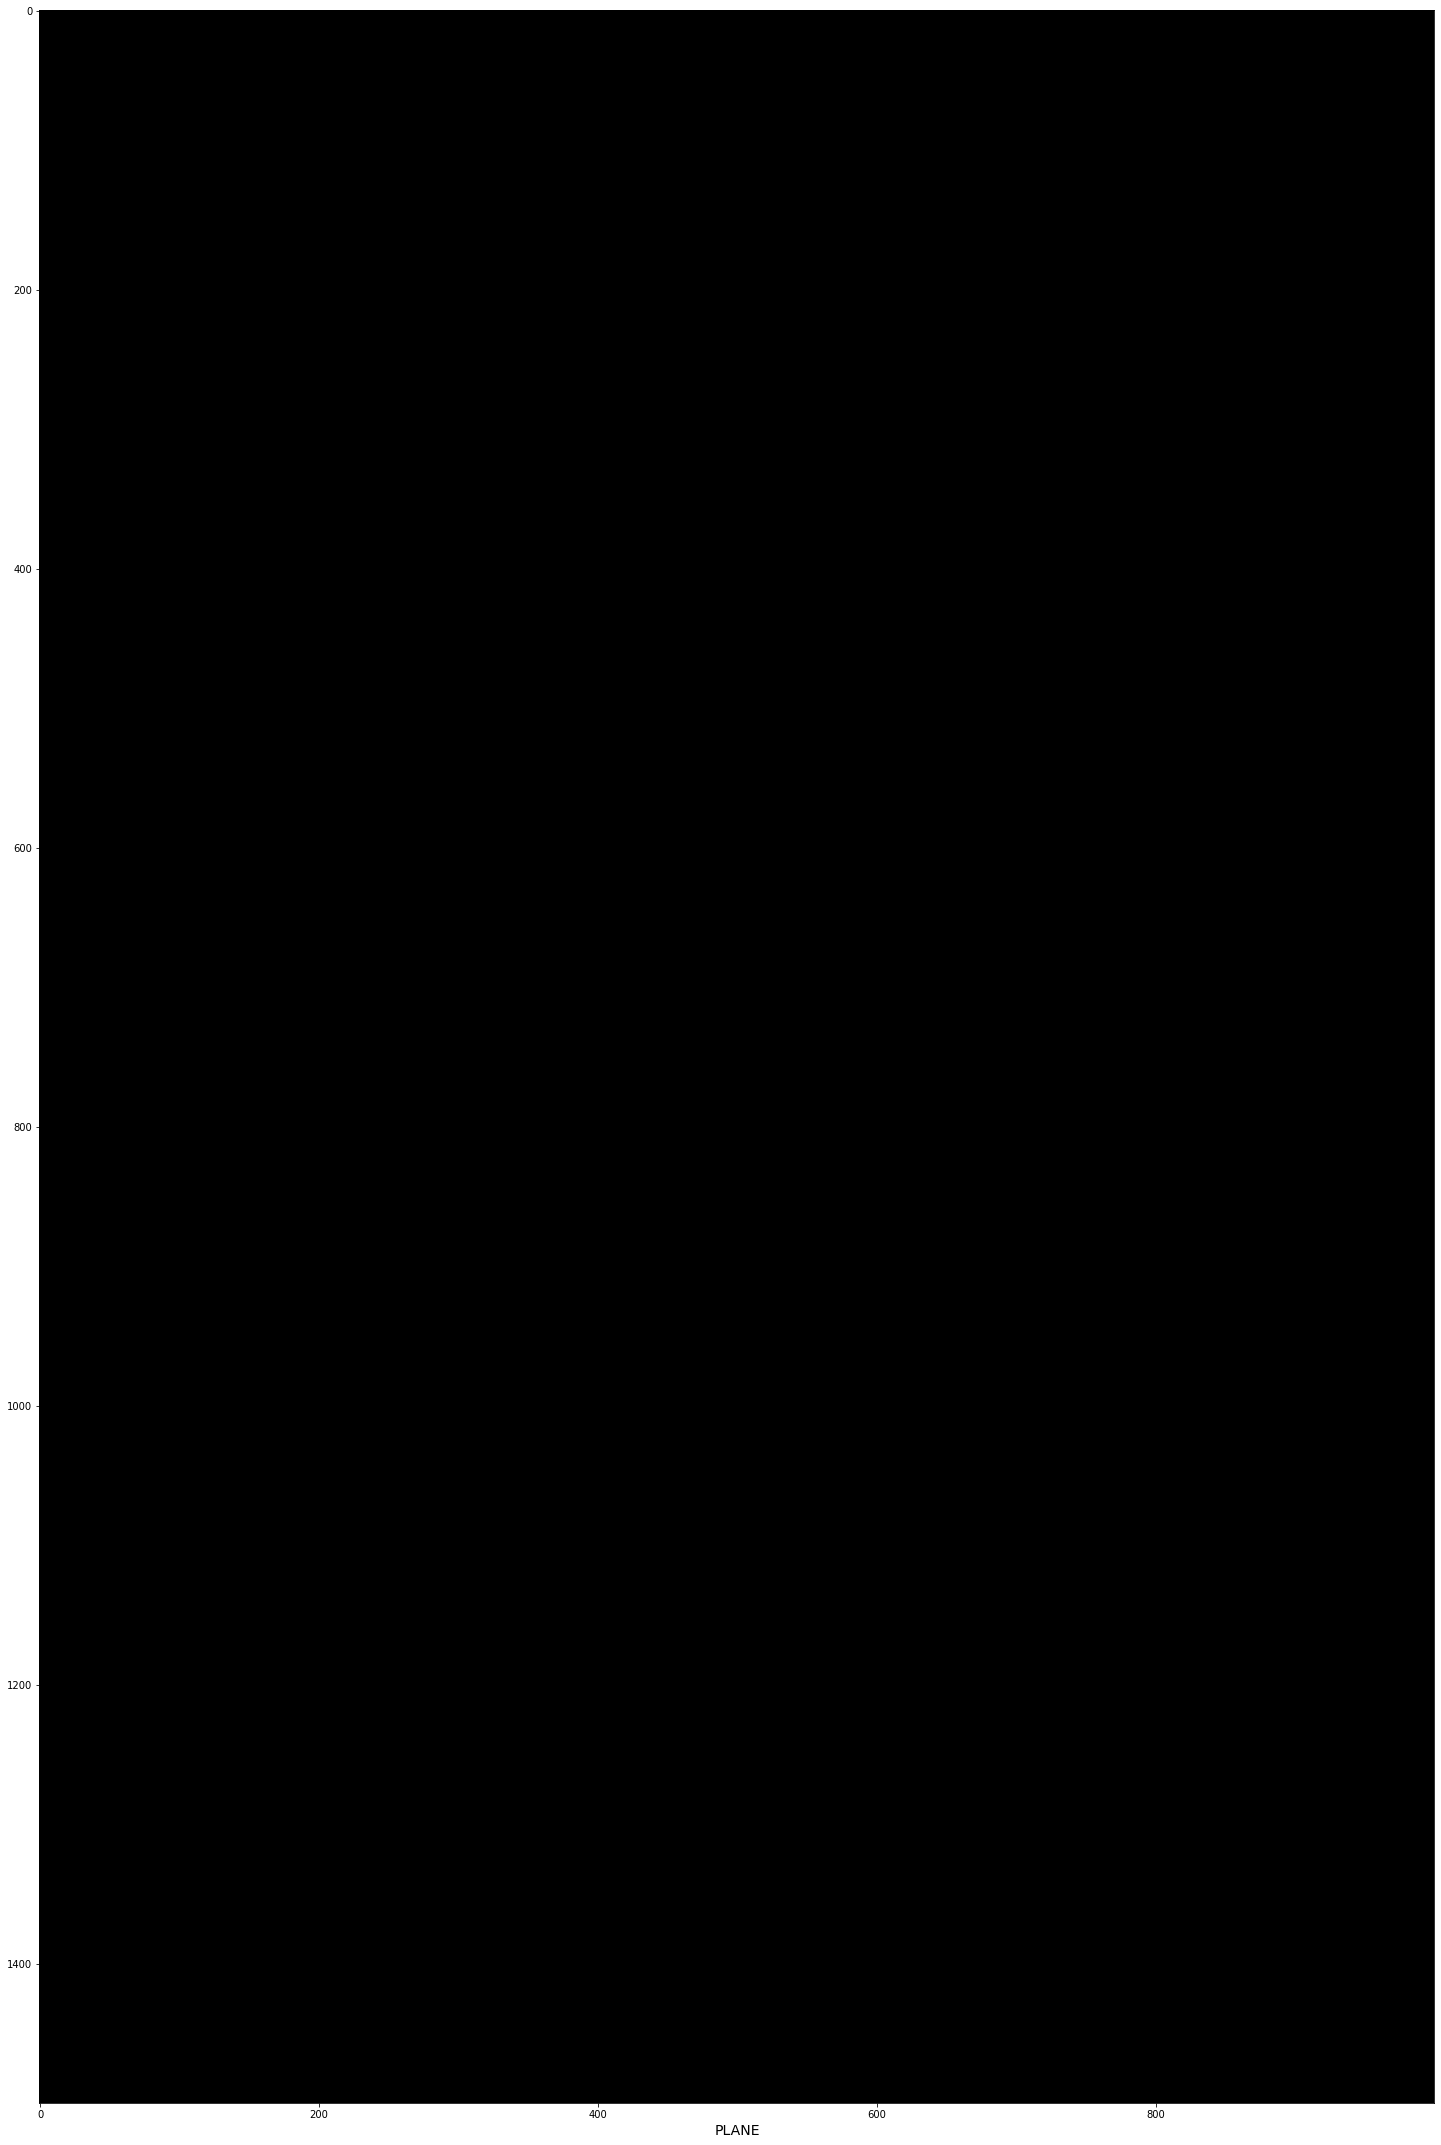

(0,)
after NMS: []


/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:281: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


AttributeError: 'list' object has no attribute 'shape'

In [17]:
# Approach 2: Counting Windows using an approximate 2D plane
## Pasting windows on an approximate 2D plane using Triangulation

## INITIALIZED VARIABLES
verticalPlane = np.zeros((1500,1000,3),np.uint8)
verticalPlaneCopy = np.copy(verticalPlane)
focalLength = 920 # in pixels
depth = 700 # in cm
nmsThresh = 0

## HEIGHT INFO OF SEQUENCE
# height_info_1 = [60, 110, 230, 330, 380, 420, 450, 480, 510, 530, 560, 580, 590, 600, 610, 670, 750, 780, 800, 850, 910, 950, 1000]
# height_info = [170, 220, 350, 420, 500, 560, 640, 700, 740, 800, 860, 910, 960, 1000]
# height_info = [160, 240, 330, 500, 580, 660, 730, 740, 910]
# height_info_4 = [90, 160, 210, 270, 330, 380, 400, 520, 580, 620, 650, 700, 760, 840, 890, 940, 980, 1000]
# height_info_2 = [50, 90, 140, 200, 230, 310, 340, 360, 420, 450, 510, 590, 640, 670, 720, 750, 780, 810, 920, 950, 970, 990]
# height_info_3 = [70, 120, 150, 170, 200, 310, 330, 390, 430, 470, 500, 520, 550, 600, 630, 690, 720, 750, 800, 860]

height_info = heights_allImages
print("Height Info Size:", len(height_info))

## Loading Coords from CSV File & Mapping to all 4 coords of Windows logic

def loadCoordsFromCSV(filePath):
    with open(filePath, newline='') as f:
        csvread = csv.reader(f)
#         print(csvread)
        batch_data = list(csvread)

    batch_data_int = []
    for inner_list in batch_data:
        innet_out_list = []
        for string in inner_list:
            innet_out_list.append(int(float(string)))
        batch_data_int.append(innet_out_list)

    FinalList = []
    for i in range(len(batch_data_int)):
        el = batch_data_int[i]
        elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
        newElChunks = elChunks.copy()
        for i in range(len(elChunks)):
            chunk = elChunks[i]
            newChunk = chunk.copy()

            newChunk.insert(2, chunk[0])
            newChunk.insert(3, chunk[3])
            newChunk.insert(6, chunk[2])
            newChunk.insert(7, chunk[1])
            newElChunks[i] = newChunk
        perImageCoords = np.array(newElChunks)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        FinalList.append(perImageCoords)

    print("Final list:", FinalList)
    print("Final list size:", len(FinalList))
    return FinalList

## Here input is in form of list of sX, sY, eX, eY
## Eg: input = [[[s1,s2, e1,e2], [s1, s2, e1, e2]],   [[s3,s4,e3,e4],[s3,s4,e3,e4]]]
def mapToAll4Coords(input):
    inputInListOfLists = [arr.tolist() for arr in input]
    finalListMappedWithAll4Coords = []
    for image in inputInListOfLists:
        finalSubList = []
        imageClone = image.copy()
        for i in range(len(image)):
            window = image[i]
            windowClone = window.copy()
            windowClone.insert(2, window[0])
            windowClone.insert(3, window[3])
            windowClone.insert(6, window[2])
            windowClone.insert(7, window[1])
            imageClone[i] = windowClone
        perImageCoords = np.array(imageClone)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        finalListMappedWithAll4Coords.append(perImageCoords)
    
    return finalListMappedWithAll4Coords

## Eg to test mapToAll4Coords()
input = [np.array([[107, 225, 255, 332]]), np.array([[100, 295, 255, 407]]), np.array([[125, 455, 275, 550], [92, 17, 255, 165]])]

input_Arr = np.array(input)
print(input_Arr)
mapped4Coords = mapToAll4Coords(input)
print(mapped4Coords)
print(mapped4Coords[0].shape)

## Loading coords from CSV File
FinalList = loadCoordsFromCSV(coordFilePath)

## Plane Mapping, NMS and Storey Logic Functions

# FOV = 82.6 degrees, imgDim = 720*960, FocalLength = 410 pixels

def mapToVerticalPlane(focalLength, depth, boundingBoxes, height, verticalPlane, img,i):
    mappedBoundingBoxes = []
    heightOfPlane = verticalPlane.shape[0]
    h, w, c = img.shape
    for box in boundingBoxes:
        sX, sY, eX, eY = box
        print(box)
        
        sY = h/2 - sY
        eY = h/2 - eY
        
        #sY = h/2 - sY - y_corrections[i]
        #eY = h/2 - eY - y_corrections[i]
        
        mappedSX, mappedSY, mappedEX, mappedEY = sX, int(heightOfPlane - ((sY*depth/focalLength) + y_corrections[i] + height)), eX, int(heightOfPlane - ((eY*depth/focalLength) + y_corrections[i] + height))
        
        print("mapped:" + str(mappedSX) + " " +  str(mappedSY)  + " " + str(mappedEX) + " " + str(mappedEY))
#         verticalPlane[mappedSY:mappedEY, mappedSX:mappedEX] = [255,255,255]
        cv2.rectangle(verticalPlane, (mappedSX, mappedSY), (mappedEX, mappedEY), (255, 255, 255), 4)
        
        mappedBoundingBoxes.append((mappedSX, mappedSY-int(y_corrections[i]), mappedEX, mappedEY-int(y_corrections[i])))
    return mappedBoundingBoxes
        

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
#         print("overlap: ", overlap)
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

############### Calculating storey #####################
def calculateStoreys(coords, heightOfPlane = 1500):
    yTop = coords[:,1]
    yBottom = coords[:,3]
    yAvg = (yTop + yBottom)/2
    storeyCount = 1 if len(coords) > 0 else 0
    index = 0
    storeyHeights = [heightOfPlane - yAvg[0]] if len(coords) > 0 else []
#     print('yTop:', yTop)
#     print('yAvg:', yAvg)
#     print('yBottom:', yBottom)    
    print('yAvg Heights:', heightOfPlane - yAvg)

    singleStoreyHeight = []
    avgStoreyHeights = []
    
    for i in range(len(coords)):
        if (((yAvg[index] > yTop[i]) and (yAvg[index] < yBottom[i])) or 
            ((yTop[index] > yTop[i]) and (yTop[index] < yBottom[i]))  or
            ((yBottom[index] > yTop[i]) and (yBottom[index] < yBottom[i]))):
            singleStoreyHeight.append(heightOfPlane - yAvg[i])
            continue
        else:
            avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
            singleStoreyHeight = []
            index = i
            storeyCounted = False
            for j in range(i):  
                if (((yAvg[index] > yTop[j]) and (yAvg[index] < yBottom[j])) or 
                    ((yTop[index] > yTop[j]) and (yTop[index] < yBottom[j])) or
                    ((yBottom[index] > yTop[j]) and (yBottom[index] < yBottom[j]))):
                    storeyCounted = True
                    break
            if(storeyCounted == False):
                storeyHeights.append(heightOfPlane - yAvg[index])
                singleStoreyHeight.append(heightOfPlane - yAvg[i])
                storeyCount+=1
                
    avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
    print('avgStoreyHeights: ', avgStoreyHeights)
    print('StoreyCount after running post processing module: ', storeyCount)
    print("storeyHeights are:", storeyHeights)
    return storeyCount, storeyHeights, avgStoreyHeights

def plotBoxes(verticalPlane, boxes):
    for box in boxes:
        sX, sY, eX, eY = box
        cv2.rectangle(verticalPlane, (sX, sY), (eX, eY), (255, 255, 255), 4)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlane, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    cv2.imwrite('after_nms_vertical_plane.png',verticalPlane)

## Running Vertical Plane Mapping



# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(imgPath)))
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
    #print(image.shape)
    images.append(image)
    print(imagePath)

windowCount = len(FinalList[0])
print("startWindowCount:", windowCount)
allMappedBoxes = []
## MAIN LOOP ##
for i in range(len(images)):
    img1 = images[i]
    
#     print(img1.shape)
    # read images and transform them to grayscale
    # Make sure that the train image is the image that will be transformed
    # Opencv defines the color channel in the order BGR 
    # Transform it to RGB to be compatible to matplotlib
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
#     img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(16,9))
    ax1.imshow(img1, cmap="gray")
    ax1.set_xlabel("img1", fontsize=14)
    plt.show()
    
    ## Preparing Binary Mask and mapping bounding box coordinates
    ## COORDS1 and COORDS2 : WOULD COME FROM TEXT FILEW
    coords1 = FinalList[i]
#     coords2 = FinalList[i+1]
    
    padding = 0

    ## Commented as the coords would come from recorded text File.
    pick1 = mapToPickv1(coords1, padding)
#     pick2 = mapToPickv1(coords2, padding)
    
    mappedBoxes = mapToVerticalPlane(focalLength,depth,pick1,height_info[i], verticalPlaneCopy, img1,i)
    allMappedBoxes = allMappedBoxes + mappedBoxes
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlaneCopy, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    
## NMS
print("before NMS:", np.array(allMappedBoxes))
plotBoxes(np.copy(verticalPlane), allMappedBoxes)
print(np.array(allMappedBoxes).shape)

finalBoxes = non_max_suppression_fast(np.array(allMappedBoxes), nmsThresh)
#finalBoxes = np.array(finalBoxes)
print("after NMS:", finalBoxes)
print(finalBoxes.shape)

plotBoxes(np.copy(verticalPlane), finalBoxes)
print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
storeyCount, storeyHeights,avgStoreyHeights = calculateStoreys(finalBoxes)

len(images)

print('finallist',len(FinalList))

## Final Result of Vertical Plane Mapping Approach 

print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
print("StoreyCount:", storeyCount)
print("storeyHeights:", storeyHeights)

print("FinalBoxes:", finalBoxes)
print("FinalBoxes (in list):", list(finalBoxes))

imu correction <br>
differences bw storey heights across vertical seq of windows <br>
differences bw centres of the windows average (intra sequence) across vertical seqs <br>
differences bw windows of a single vertical set <br>
    Height Differences between storeys of a single vertical sequence <br>
    
averge building height and storey height across all seq for final ans <br>
plot imu height data and all seq height data to compare <br>

In [ ]:
# Height Differences between stories of a single vertical sequence
np.diff(np.array(storeyHeights))

In [ ]:
# apply offset using imu data of the first image captured
# offset is due to the ground ground visibility in the first capture
# --- Assuming the the camera is orthogonal and in level with the window 
# --- (window centre and camera centre coinciding)


offset_building = avgStoreyHeights[0] - heights_allImages[0]
offset_ramp = 15 #cm 001
#offset_ramp = 81 #cm 002
#offset_ramp = 0 #cm 003

offset_final = offset_building - offset_ramp
print(offset_final)
storeyHeights_final = avgStoreyHeights - offset_final*(np.array(np.ones(len(avgStoreyHeights))))
print('final storey heights', storeyHeights_final)

In [ ]:
np.diff(np.array(avgStoreyHeights))

In [ ]:
print('Height difference between 2 consecutive stories of a single vertical sequence', 
      np.diff(np.array(storeyHeights_final)))

In [ ]:
# imu plot data for this seq
plt.figure()
plt.plot(heights_allImages, label = 'IMU All Image Height Data')
plt.plot(storeyHeights_final, label = 'Storey Heights of a ' + str(storeyCount) + ' storey sequence')
t_line = range(len(heights_allImages))
for i in range(len(storeyHeights_final)):
    plt.plot(t_line, np.repeat(storeyHeights_final[i], len(heights_allImages)),
             label = str(len(storeyHeights_final) - i - 1) + ' storey avg height', 
plt.legend(bbox_to_anchor=(2, 1))
plt.title('Average or Mid heights of stories')
plt.show()